<a name="Installation"></a>
## Installation

In [12]:
%%capture
# Normally using pip install unsloth is enough
# %conda install unsloth

# Temporarily as of Jan 31st 2025, Colab has some issues with Pytorch
# Using pip install unsloth will take 3 minutes, whilst the below takes <1 minute:
%pip install --no-deps bitsandbytes accelerate xformers peft trl triton
%pip install --no-deps cut_cross_entropy unsloth_zoo
%pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
%pip install --no-deps unsloth
%pip install pandas

%pip install torch torchvision torchaudio

In [ ]:
### VERIFYING TORCH INSTALLATION ###

import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

2.6.0+cu124
CUDA Available: True


In [ ]:
### SELECTING GPU ###

import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(torch.cuda.device_count())

<a name="Unsloth"></a>
## Unsloth

In [1]:
### HYPER-PARAMETERS ###

from unsloth import is_bfloat16_supported

# all the models we fine-tuned
ALL_MODELS = [
    # Qwen2.5-oder
    "unsloth/Qwen2.5-Coder-3B",
    "unsloth/Qwen2.5-Coder-7B",
    "unsloth/Qwen2.5-Coder-14B-bnb-4bit",
    "unsloth/Qwen2.5-Coder-32B-bnb-4bit",
    # CodeLlama
    "unsloth/codellama-7b",
    "unsloth/codellama-13b-bnb-4bit",
    "unsloth/codellama-34b-bnb-4bit",
    # CodeGemma
    "unsloth/codegemma-7b-it"
]

BASE_MODEL_PATH = "unsloth/Qwen2.5-Coder-7B"    # used to load the base model
MODEL_LABEL = "qwen-7B"     # used to create results file name

LOAD_IN_4BIT = False

# LoRA Parameters
LORA_ALPHA = 64
LORA_R = 32
LORA_DROPOUT = 0

# File paths
TRAIN_FILE = "../train.json"
VALID_FILE = "../valid.json"
TEST_FILE = "../test.json"

# Training Hyperparameters
PER_DEVICE_TRAIN_BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 4
WARMUP_STEPS = 100      # 5-10% of total steps was suggested
NUM_TRAIN_EPOCHS = 3
MAX_STEPS = 0
LEARNING_RATE = 1e-4
FP16 = not is_bfloat16_supported()
BF16 = is_bfloat16_supported()
LOGGING_STEPS = 10
OPTIM = "adamw_8bit"
WEIGHT_DECAY = 0.01
LR_SCHEDULER_TYPE = "linear"
SEED = 3407
REPORT_TO = "none"  # Use this for WandB etc
EVAL_STEPS = 10


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
### LOADING THE BASE MODEL ###

from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = LOAD_IN_4BIT

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = BASE_MODEL_PATH,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.3.8: Fast Qwen2 patching. Transformers: 4.46.2.
   \\   /|    NVIDIA RTX 6000 Ada Generation. Num GPUs = 2. Max memory: 47.467 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [4]:
### ADDING LORA CONFIGURATION ###

model = FastLanguageModel.get_peft_model(
    model,
    r = LORA_R,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = LORA_ALPHA,
    lora_dropout = LORA_DROPOUT,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False, 
    loftq_config = None,
)

Unsloth 2025.3.8 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


<a name="Data"></a>
## Data Prep

In [5]:
### READ THE ALPACA JSON FILE AND SEGMENT INTO TRAIN, VALIDATE, AND TEST ###

import json
import pandas as pd
from datasets import Dataset

# Function to load JSON file into a Pandas DataFrame
def load_json_to_df(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)  # Assumes JSON contains a list of dictionary entries
    return pd.DataFrame(data)

# Load datasets as DataFrames
train_df = load_json_to_df(TRAIN_FILE)
valid_df = load_json_to_df(VALID_FILE)
test_df = load_json_to_df(TEST_FILE)

# Convert DataFrames into Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

# Display first few rows of Train DataFrame
train_df.head()

,instruction,input,output
0,Write a header comment for this x86 assembly c...,"xor %eax, %eax\npush %eax\npush %eax\nm...","/*\n * $Id: portbind-bsd.c,v 1.3 2004/06/02 12..."
1,Write a header comment for this x86 assembly c...,char shellcode[]=\n\njmp <_shellcode+39>\n...,"/*\n *BSD version\n FreeBSD, OpenBSD, NetB..."
2,Write a header comment for this x86 assembly c...,\tSECTION .text\n\tglobal main\nmain:\n\tmov\t...,"; For positive integer values of rax and rdx, ..."
3,Write a header comment for this x86 assembly c...,"xor %eax, %eax\nmov $0x25, %al\npush $...",/*\nExploit database separated by exploit\ntyp...
4,Write a header comment for this x86 assembly c...,"_start:\n xor rax, rax\n xor rdi, ...",/*\nTitle : tcpbindshell (150 bytes)\nTestd...


In [6]:
### LOAD THE DATASET ###

from datasets import load_dataset

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []

    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)

    return { "text" : texts, }
pass

train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)
valid_dataset = valid_dataset.map(formatting_prompts_func, batched = True,)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

train_dataset = train_dataset.shuffle()
valid_dataset = valid_dataset.shuffle()
test_dataset = test_dataset.shuffle()


Map:   0%|          | 0/4185 [00:00<?, ? examples/s]

Map:   0%|          | 0/597 [00:00<?, ? examples/s]

Map:   0%|          | 0/1199 [00:00<?, ? examples/s]

<a name="Train"></a>
## Training

In [7]:
### CREATE DIRECTORY FOR OUTPUT STATS ###

import os
import re

# Create base directory if it doesn't exist
os.makedirs(MODEL_LABEL, exist_ok=True)

# Get existing iterations
existing = [
    int(match.group(1)) for name in os.listdir(MODEL_LABEL)
    if (match := re.match(fr"{re.escape(MODEL_LABEL)}-(\d+)", name))
]

# Set ITERATION to next available number
ITERATION = max(existing, default=0) + 1

directory = f"{MODEL_LABEL}/{MODEL_LABEL}-{ITERATION}"

os.makedirs(directory, exist_ok=True)

OUTPUT_DIR = f"{MODEL_LABEL}/{MODEL_LABEL}-{ITERATION}/checkpoints"


In [8]:
### GENERATE THE TRAINER ###

from trl import SFTTrainer
from transformers import TrainingArguments, TrainerCallback
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,  # train dataset
    eval_dataset=valid_dataset,     # Validation data
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
        gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
        warmup_steps=WARMUP_STEPS,
        num_train_epochs=NUM_TRAIN_EPOCHS,  # Set this for 1 full training run.
        max_steps=MAX_STEPS,
        learning_rate=LEARNING_RATE,
        fp16=FP16,
        bf16=BF16,
        logging_steps=LOGGING_STEPS,
        evaluation_strategy="steps",  # Runs validation periodically
        eval_steps=EVAL_STEPS,        # Controls how often validation runs
        save_strategy="epoch",        # Saves checkpoint each epoch
        optim=OPTIM,
        weight_decay=WEIGHT_DECAY,
        lr_scheduler_type=LR_SCHEDULER_TYPE,
        seed=SEED,
        output_dir=OUTPUT_DIR,
        report_to=REPORT_TO,  # Use this for WandB etc
    ),
)

# class called on every logging step to collect loss data
class LossCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.train_loss_data = [] 
        self.eval_loss_data = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            step = state.global_step
            train_loss = logs.get("loss", None)
            val_loss = logs.get("eval_loss", None)

            if train_loss != None:
                self.train_loss_data.append({"step": step, "train_loss": train_loss})

            if val_loss != None:
                self.eval_loss_data.append({"step": step, "val_loss": val_loss})

    def get_dataframe(self):
        """Returns the collected loss data as a Pandas DataFrame."""
        return pd.DataFrame(self.train_loss_data), pd.DataFrame(self.eval_loss_data)
    
loss_callback = LossCallback()

trainer.add_callback(loss_callback)

/home/darrin_lea/miniconda3/envs/thesis/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/darrin_lea/miniconda3/envs/thesis/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Tokenizing to ["text"] (num_proc=2):   0%|          | 0/4185 [00:00<?, ? examples/s]

Tokenizing to ["text"] (num_proc=2):   0%|          | 0/597 [00:00<?, ? examples/s]

In [11]:
### CURRENT MEMORY STATS ###

gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX 6000 Ada Generation. Max memory = 47.467 GB.
24.842 GB of memory reserved.


In [ ]:
### TRAIN ###

trainer_stats = trainer.train()

In [ ]:
### FINAL MEMORY STATS ###

used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4450.8547 seconds used for training.
74.18 minutes used for training.
Peak reserved memory = 21.402 GB.
Peak reserved memory for training = 5.728 GB.
Peak reserved memory % of max memory = 45.088 %.
Peak reserved memory for training % of max memory = 12.067 %.


TrainOutput(global_step=783, training_loss=0.5144985258046391, metrics={'train_runtime': 4450.8547, 'train_samples_per_second': 2.821, 'train_steps_per_second': 0.176, 'total_flos': 1.6466556717357466e+17, 'train_loss': 0.5144985258046391})


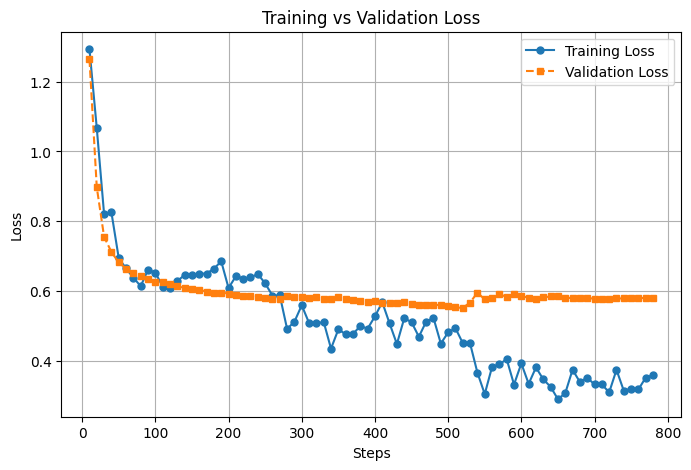

In [ ]:
### PLOT LOSS ###

import matplotlib.pyplot as plt
import pandas as pd

print(trainer_stats)

train_loss_data, eval_loss_data = loss_callback.get_dataframe()

plot_filename = f"./{MODEL_LABEL}/{MODEL_LABEL}-{ITERATION}/{MODEL_LABEL}-{ITERATION}.png"

# print(train_loss_data)
# print(eval_loss_data)


train_max = max(train_loss_data["train_loss"])  # Get the max y value from data
eval_max = max(eval_loss_data["val_loss"])
y_max = max(train_max, eval_max)
# upper_bound = max(3, y_max)  # Ensure the upper bound is at least 3

# Create the plot
plt.figure(figsize=(8, 5))
# plt.ylim(0, upper_bound)
plt.plot(train_loss_data["step"], train_loss_data["train_loss"], label="Training Loss", marker="o", linestyle="-", markersize=5)
plt.plot(eval_loss_data["step"], eval_loss_data["val_loss"], label="Validation Loss", marker="s", linestyle="--", markersize=5)

# Formatting the plot
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.savefig(plot_filename)  # Saves as a PNG file

# Show the plot
plt.show()

In [ ]:
### GENERATE JSON OUTPUT ###

import json
import torch

directory = f"./{MODEL_LABEL}/{MODEL_LABEL}-{ITERATION}/"

# get min validation loss
min_eval_loss = min(eval_loss_data["val_loss"])
step = eval_loss_data.loc[eval_loss_data["val_loss"] == min_eval_loss, "step"].values[0]

min_validation_loss = {
    "value": min_eval_loss,
    "step": int(step)
}

# Parameters
config = {
    "PER_DEVICE_TRAIN_BATCH_SIZE": PER_DEVICE_TRAIN_BATCH_SIZE,
    "GRADIENT_ACCUMULATION_STEPS": GRADIENT_ACCUMULATION_STEPS,
    "WARMUP_STEPS": WARMUP_STEPS,
    "NUM_TRAIN_EPOCHS": NUM_TRAIN_EPOCHS,
    "MAX_STEPS": MAX_STEPS,
    "LEARNING_RATE": LEARNING_RATE,
    "FP16": FP16,
    "BF16": BF16,
    "LOGGING_STEPS": LOGGING_STEPS,
    "OPTIM": OPTIM,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "LR_SCHEDULER_TYPE": LR_SCHEDULER_TYPE,
    "SEED": SEED,
    "OUTPUT_DIR": OUTPUT_DIR,
    "REPORT_TO": REPORT_TO,
    "EVAL_STEPS": EVAL_STEPS,
}

# GPU stats
max_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)  # in GB
start_gpu_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # in GB
used_memory = round(torch.cuda.max_memory_reserved() / (1024 ** 3), 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

gpu_stats = {
    "used_memory": used_memory,
    "used_memory_for_lora": used_memory_for_lora,
    "used_percentage": used_percentage,
    "lora_percentage": lora_percentage
}

lora_params = {
    "lora_alpha": LORA_ALPHA,
    "lora_r":  LORA_R,
    "lora_dropout": LORA_DROPOUT
}

lora_parameters ={
    "Lora_rank": LORA_R,
    "lora_alpha": LORA_ALPHA
}

# Combine all data into a single object
output_data = {
    "trainer_stats": trainer_stats,
    "min_validation_loss": min_validation_loss,
    "config": config,
    "gpu_stats": gpu_stats,
    "lora_params": lora_params
}

# Write the combined data to a JSON file
with open(directory + "training_stats.json", "w") as json_file:
    json.dump(output_data, json_file, indent=4)

print("Data written to training_stats.json")

Data written to training_stats.json


In [ ]:
### SAVE THE MODEL ###

# Change to True to save a specific checkpoint
if False:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=f"./{MODEL_LABEL}/{MODEL_LABEL}-{ITERATION}/checkpoints/checkpoint-522",
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit
    )

    # Save the model and tokenizer to the new directory
    model.save_pretrained(f"./{MODEL_LABEL}-fine-tuned")
    tokenizer.save_pretrained(f"./{MODEL_LABEL}-fine-tuned")

## Testing

In [ ]:
### OPTIONALLY LOAD IN A MODEL ###

# Change to Treu to load in the model that was just saved
if False:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=f"./{MODEL_LABEL}-fine-tuned",
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit
    )

In [ ]:
### TEST THE MODEL ###

INSTRUCTION = "Write a header comment for the following snippet of assembly code"

prompt = '''Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}'''
inputs = tokenizer(
[
    prompt.format(
        INSTRUCTION,
        '''section .data
            message db "Hello, World!", 0xA
            msg_len equ $ - message

        section .text
            global _start

        _start:
            mov rax, 1
            mov rdi, 1
            mov rsi, message 
            mov rdx, msg_len
            syscall

            mov rax, 60
            xor rdi, rdi
            syscall''',
        ""

    )
], return_tensors = "pt").to("cuda")

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

outputs = model.generate(**inputs, max_new_tokens = 200, use_cache = True)
tokenizer.batch_decode(outputs)

['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWrite a header comment for the following snippet of assembly code\n\n### Input:\nsection .data\n            message db "Hello, World!", 0xA\n            msg_len equ $ - message\n\n        section .text\n            global _start\n\n        _start:\n            mov rax, 1\n            mov rdi, 1\n            mov rsi, message\n            mov rdx, msg_len\n            syscall\n\n            mov rax, 60\n            xor rdi, rdi\n            syscall\n\n### Response:\n; This is a simple "Hello, World!" program in x86_64 assembly. It\n; prints the message to the console and then exits. The message is\n; stored in the message variable and the length of the message is\n; calculated and stored in msg_len. The program uses the write and\n; exit system calls to print the message and exit the program\n; respectively.\n